# Trust Experiments

Here we look at the effect of constant vs. dynamic physician trust in our model. We do this for various initial FPR rates as the relation between final (converged) FPR and the physician trust depends heavily on initial FPR. We'll use `sklearn.datasets.make_classification` to generate the data

In [1]:
import copy
import numpy as np
import torch

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt

import sklearn.linear_model as linear_model

from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from utils import eval_model, perturb_labels_fp, update_model_constant_trust, update_model_conditional_trust, update_model_monotonically_increasing_trust

## Train Initial Model

In [2]:
np.random.seed(1)
x, y = make_classification(100000, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9)
x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=0.5)

model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
model.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=True)

In [3]:
y_pred = model.predict(x_test)
initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)
print("Initial FPR: {}".format(initial_fpr))
print("Initial TPR: {}".format(initial_tpr))
print("Initial FNR: {}".format(initial_fnr))
print("Initial TNR: {}".format(initial_tnr))

Initial FPR: 0.03746666666666667
Initial TPR: 0.45782222222222224
Initial FNR: 0.041044444444444446
Initial TNR: 0.46366666666666667


## Update Model --> Constant Trust

In [5]:
trust_rates = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
physician_fprs = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]
results = {trust: {} for trust in trust_rates}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        new_model = update_model_constant_trust(model, x_update, y_update, 1000, trust, physician_fpr)
        
        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
        
        results[trust][physician_fpr] = updated_fpr

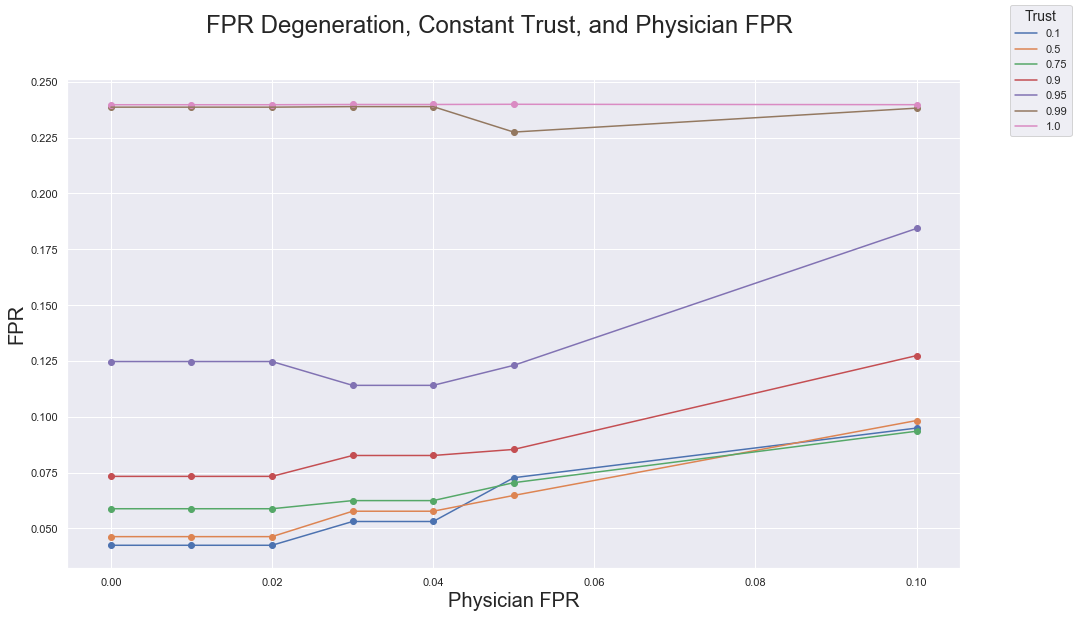

In [6]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Constant Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Physician FPR", fontsize=20)

for count, i in enumerate(trust_rates):
    ax.plot(list(results[i].keys()), list(results[i].values()), label=str(i))
    ax.scatter(list(results[i].keys()), list(results[i].values()))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="Trust", title_fontsize=14)
fig.show()

## Update Model --> Trust Decreasing with FPR

In [4]:
trust_rates = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
physician_fprs = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
results = {trust: {} for trust in trust_rates}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        new_model = update_model_conditional_trust(model, x_update, y_update, 1000, trust, physician_fpr)
        
        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
        
        results[trust][physician_fpr] = updated_fpr

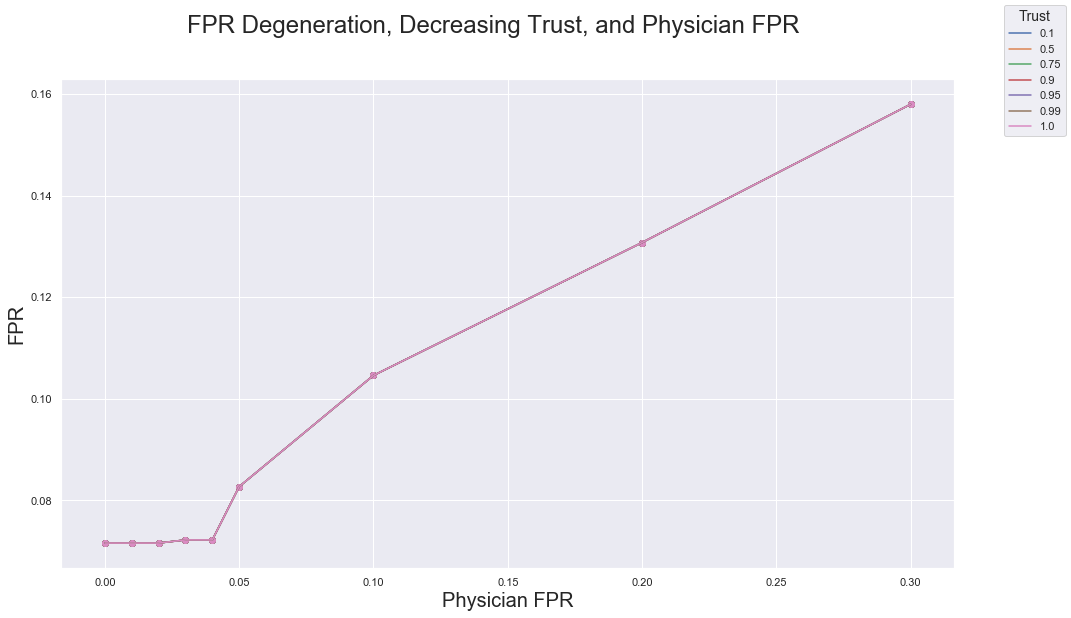

In [5]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Decreasing Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Physician FPR", fontsize=20)

for count, i in enumerate(trust_rates):
    ax.plot(list(results[i].keys()), list(results[i].values()), label=str(i))
    ax.scatter(list(results[i].keys()), list(results[i].values()))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="Trust", title_fontsize=14)
fig.show()

## Update Model --> Monotonically Linearly Increasing Trust

In [4]:
trust_rates = [0.1, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
physician_fprs = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
results = {trust: {} for trust in trust_rates}

for trust in trust_rates:
    for physician_fpr in physician_fprs:
        new_model = update_model_monotonically_increasing_trust(model, x_update, y_update, 1000, trust, physician_fpr)
        
        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)
        
        results[trust][physician_fpr] = updated_fpr

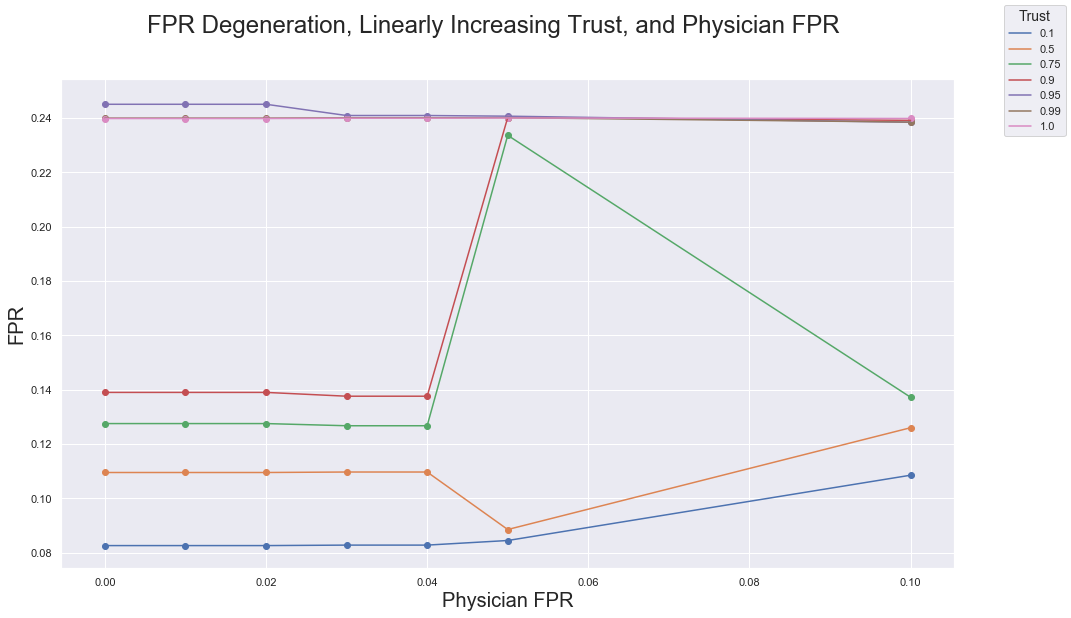

In [6]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("FPR Degeneration, Linearly Increasing Trust, and Physician FPR", fontsize=24)

ax = fig.add_subplot(111)
ax.set_ylabel("FPR", fontsize=20)
ax.set_xlabel("Physician FPR", fontsize=20)

for count, i in enumerate(trust_rates):
    ax.plot(list(results[i].keys()), list(results[i].values()), label=str(i))
    ax.scatter(list(results[i].keys()), list(results[i].values()))

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', title="Trust", title_fontsize=14)
fig.show()